# ECE 450 - Exam #4

## Code Appendix


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from control import margin, tf


### Generic function to convolve any number of equations


In [2]:
def convolve_all(values):
    temp_conv = values[0]
    if len(values) > 1:
        for next_val in values[1:]:
            temp_conv = np.convolve(temp_conv, next_val)
    
    return temp_conv


### Generic function to create plots


In [3]:
# Color list for multiple lines on each subplot
colors = ["red", "blue", "green", "gray", "purple", "orange"]

# Generic Function to create a plot
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"], title=[("Plot", )],
                size=(18, 14), logx=False, y_lines=[[np.nan]], y_line_labels=[[""]], ylim=None):
    plt.figure(figsize=size, dpi=300)
    for c, (x_vals, y_vals, x_labels, y_labels, titles, lines, line_labels) in enumerate(zip(x, y, xLabel, yLabel, title, y_lines, y_line_labels)):
        if ylim is not None:
            for lims in ylim:
                plt.ylim(lims[0], lims[1])
        for line, label in zip(lines, line_labels): # Add each vertical line to this plot
            plt.axvline(x=line, linestyle='--', label=label)
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(len(x), 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            plt.plot(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='lower right')
            if logx:
                plt.xscale("log")
    
    plt.show()


### Generic function to generate the Bode plots of a transfer function


In [4]:
def magnitude_phase_response(num, den, omega_range, omega_step=10, gain_num=None, gain_den=None):
    if isinstance(gain_num, (np.ndarray, list)) and isinstance(gain_den, (np.ndarray, list)):
        num = convolve_all([num, gain_num])
        den = convolve_all([den, gain_den])
        
    system = sig.lti(num, den)
    w, h_mag, h_phase = sig.bode(system, np.arange(omega_range[0], omega_range[1], omega_step))
    _, phase_margin, _, crossover_w = margin(h_mag, h_phase, w)
    
    return w, h_mag, h_phase, phase_margin, crossover_w


### Generic function to generate an $nth$ order Buttersworth Filter


In [5]:
def buttersworth_tf(order):
    pole_list = [np.sin((np.pi * (2 * k - 1))/(2 * order)) + complex(0, np.cos((np.pi * (2 * k - 1))/(2 * order))) for k in range(1, order+1)]
    s_pole_list = [[1, pole] for pole in pole_list]

    return convolve_all(s_pole_list)


### Generic function to shift a given filter to a new center frequency


In [6]:
def shift_filter(num, den, new_center):
    new_num = np.pad(num, (len(den) - len(num), 0), 'constant')
    new_den = den

    for i in range(len(new_den)):
        new_num[i] *= (new_center ** i)
        new_den[i] *= (new_center ** i)
        
    return np.real(new_num), np.real(new_den)


### Generic function to convert a given lowpass filter to a bandpass filter


In [7]:
# This function assumes the numerator is just a constant, no s-terms
def convert_to_bandpass(num, den, w_c):
    num = np.trim_zeros(num, 'f') # Trim front-leading zeros
    den = np.trim_zeros(den, 'f') 
    num = np.concatenate((num, [0] * (len(den) - 1))) # Shift num. by s^n
    temp_den = np.zeros((len(den) - 1) * 2 + 1)
    for power, constant in enumerate(den[::-1]):
        if power is 0:
            temp_den[-len(den)] = constant # Add in non-s term, shifted by s^n
            continue
            
        # Get product of the (s^2+wc^2)^n for this current power of s^n
        non_shifted = np.multiply(constant, convolve_all([[1, 0, w_c ** 2] for _ in range(power)]))
        # Shift by the multiplied s^n/s^n
        shifted = np.pad(non_shifted, (0, len(den)-power-1), mode='constant')
        # Add to running total den.
        temp_den = np.add(temp_den, np.pad(shifted, (len(temp_den)-len(shifted), 0), mode='constant'))
    
    return np.real(num), np.real(temp_den)


### Generic function to create a plot of a z-domain transfer function


In [8]:
def z_plot(num, den, T, phi_range=[None, np.pi]):
    phi_range[0] = T if phi_range[0] is None else phi_range[0]
    phi = np.arange(phi_range[0], phi_range[1], T)
    angles = angles = [np.exp(complex(0, angle)) for angle in phi]
    
    # Loop through all angles, calculate that angles H(z)
    h_z = []
    for z in angles:
        num_sum, den_sum = 0, 0
        for z_pow, num_val in enumerate(num):
            num_sum += num_val * z ** (len(num) - z_pow)
        for z_pow, den_val in enumerate(den):
            den_sum += den_val * z ** (len(den) - z_pow)
        h_z.append(num_sum / den_sum)
    
    return np.multiply(180 / np.pi, phi), 20 * np.log10(h_z)


### Generic function to convert a given frequency to it's z-domain angle


In [9]:
def convert_z_angle(omega, T):
    return omega * T * 180 / np.pi


## Problem A

### Obtain the transfer function $H_{BP}(s)$


In [10]:
# Define the variables of this problem
passband_low, passband_high = 0.2e6, 2e6
stopband_low, stopband_high = 0.04e6, 10e6
h_p_db, h_s_db = -3, -25

bandwidth = (passband_high - passband_low) * 1.1 # Expand the bandwidth a bit 
center_freq = .6e6 # Trial and error found this to accomplish the desireable attenuation
h_p, h_s = 10 ** (0.05 * h_p_db), 10 ** (0.05 * h_s_db)
w_p, w_s = 1, (stopband_high - stopband_low) / (center_freq)

# Find the number of poles needed
n = int(np.ceil(np.log10(1 / (h_s ** 2) - 1) / (2 * np.log10(w_s))))

# Generate the low-pass filter with a corner frequency of 1
num_lp = [1]
den_lp = buttersworth_tf(n)

# Transform to a low-pass filter at the desired bandwidth
num_lp_shifted, den_lp_shifted = shift_filter(num_lp, den_lp, bandwidth)

# Transform to a bandpass filter with G_lp((s^2+center^2)/s)
num_bp, den_bp = convert_to_bandpass(num_lp_shifted, den_lp_shifted, center_freq)
print ("Num: ", num_bp, "\nDen: ", np.real(den_bp))

Num:  [3920400000000             0             0] 
Den:  [1.00000000e+00 2.80014285e+06 4.64040000e+12 1.00805143e+18
 1.29600000e+23]



### Plot the transfer function $H_{BP}(s)$


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


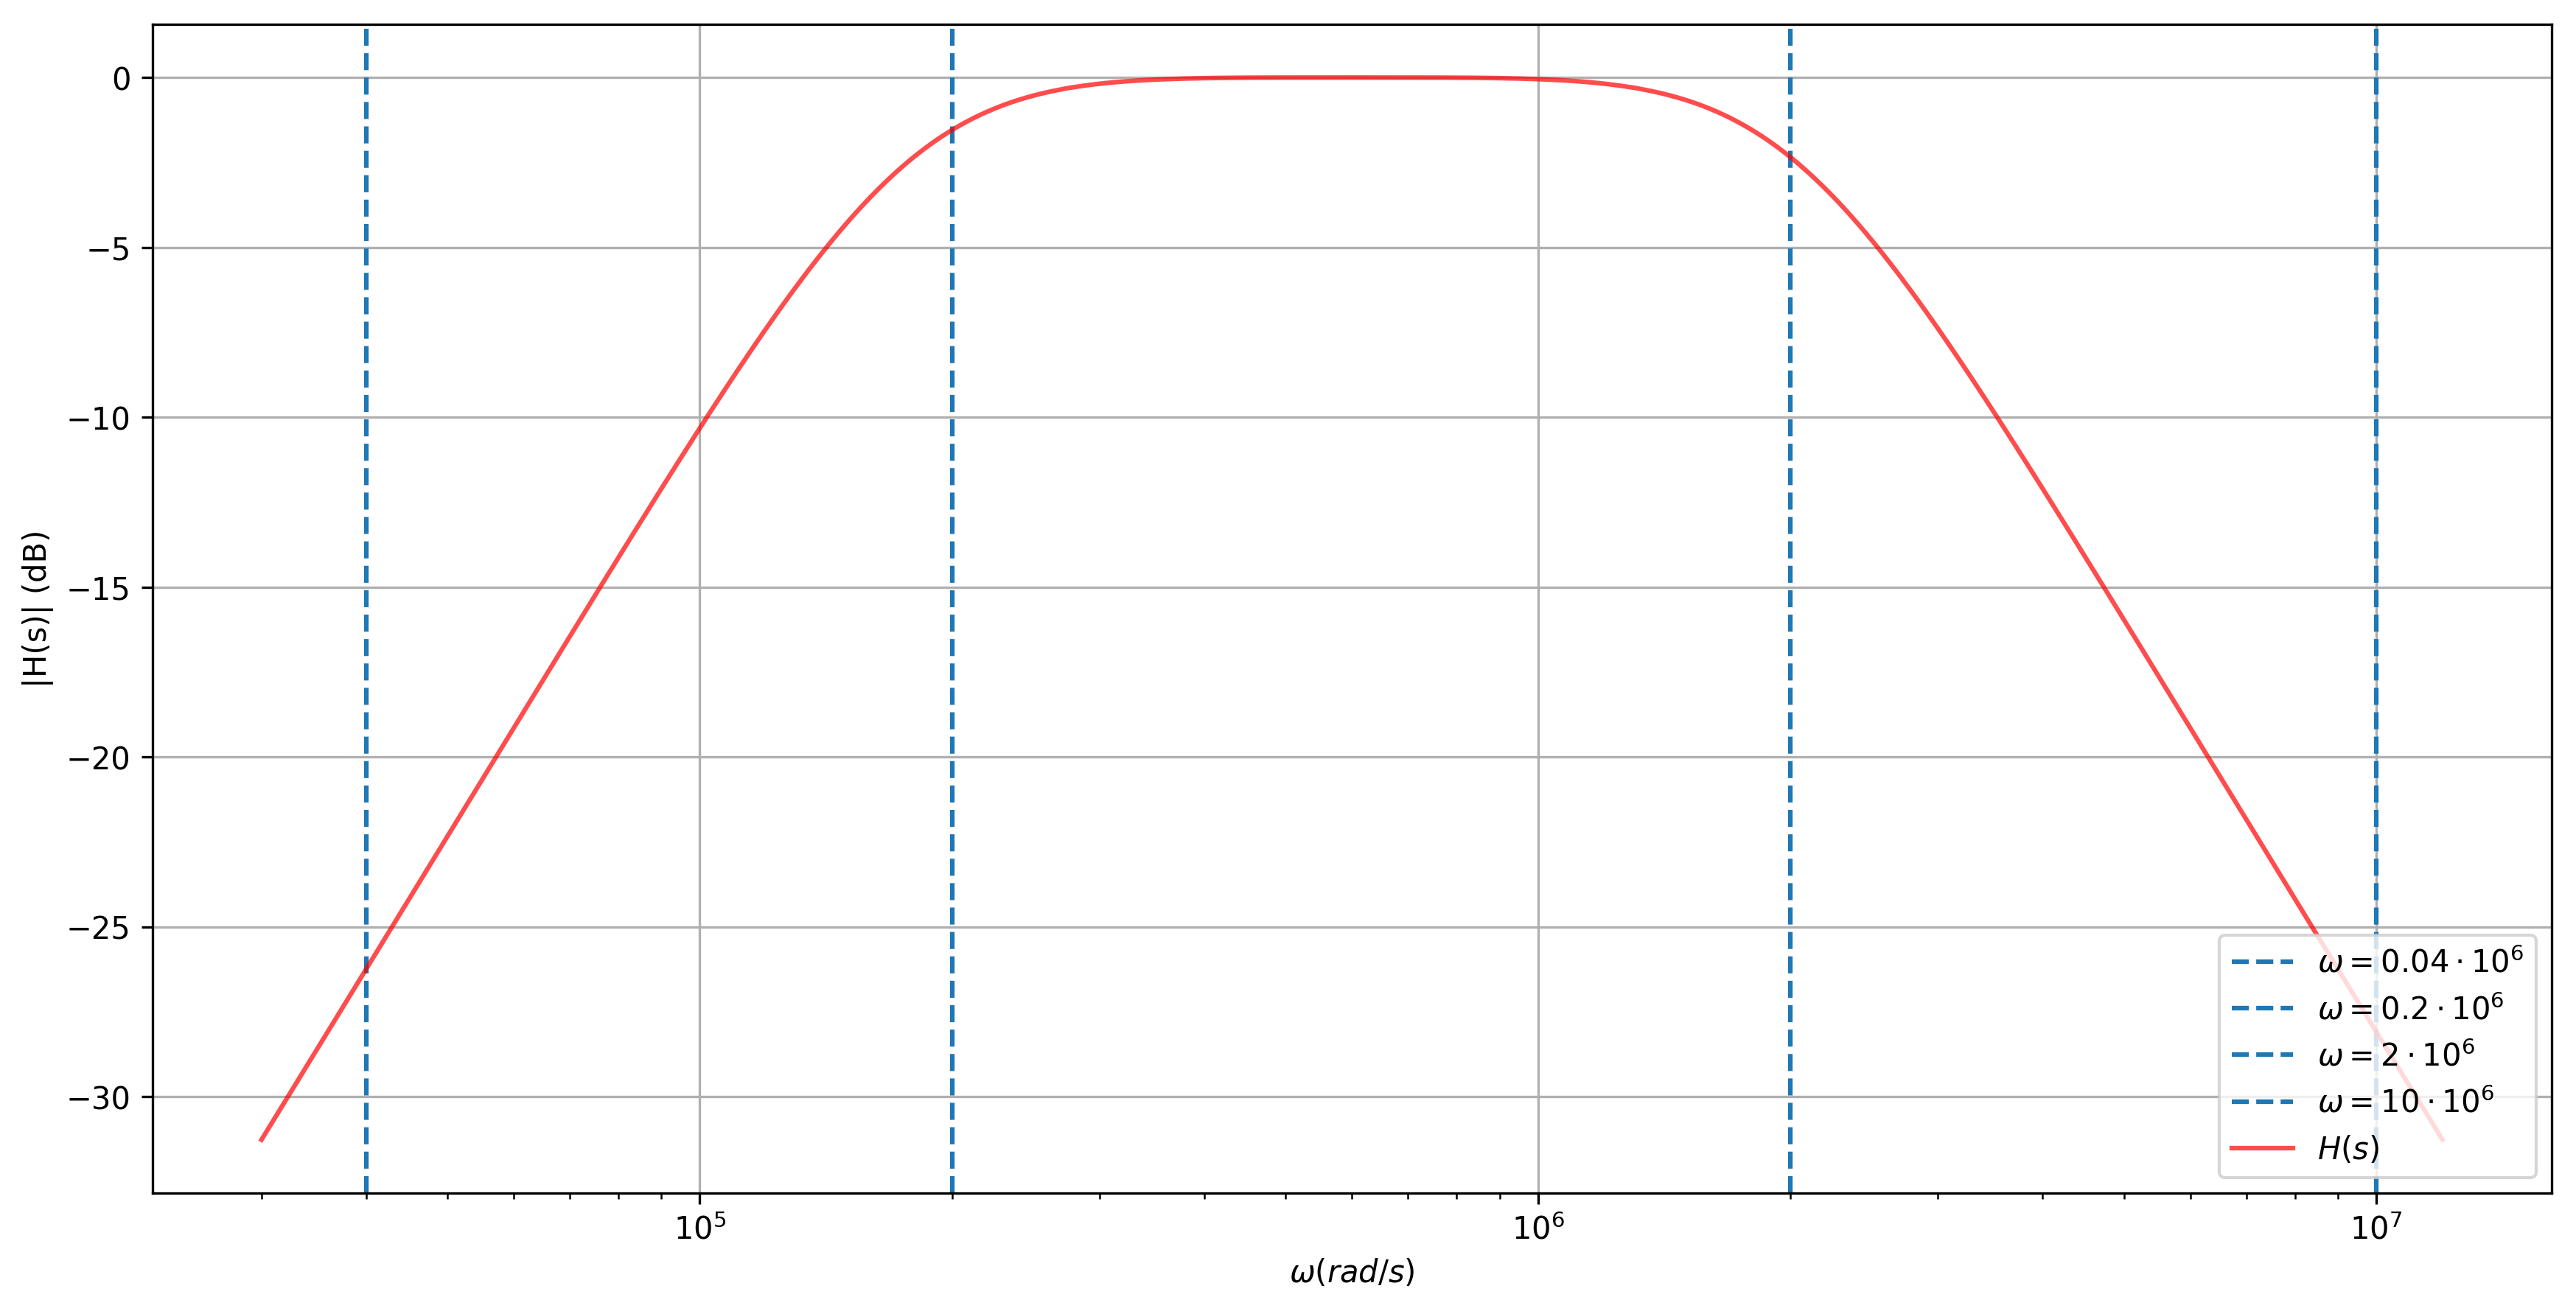

In [11]:
w, h_mag, _, _, _ = magnitude_phase_response(num_bp, den_bp, [0.03e6, 12e6], omega_step=1000)
create_plot([w], [(h_mag, )], ["$\omega (rad/s)$"], ["|H(s)| (dB)"], [("$H(s)$", )], logx=True,
            y_lines=[[stopband_low, passband_low, passband_high, stopband_high]],
            y_line_labels=[["$\omega = 0.04\cdot 10^6$", "$\omega = 0.2\cdot 10^6$",
                            "$\omega = 2\cdot 10^6$", "$\omega = 10\cdot 10^6$"]], size=(14, 7))


### Verify $H(s)$  meets the given attenuation criteria


In [12]:
df = pd.DataFrame(np.transpose([w, h_mag]), columns=["$\omega$", "$|H(s)|$"])
df[(df["$\omega$"]==passband_low) | (df['$\omega$'] == passband_high) |\
   (df['$\omega$'] == stopband_low) | (df['$\omega$'] == stopband_high)]

,$\omega$,$|H(s)|$
10,40000.0,-26.236057
170,200000.0,-1.542419
1970,2000000.0,-2.339802
9970,10000000.0,-28.077508



### Convert $H(s)$ to $H(z)$ using the backwards rectangular approximation

T = 50e-9

$$H(z)=H(\frac{1-z^{-1}}{T})=\frac{3.9204e12(\frac{1-z^{-1}}{50e-9})^2}{(\frac{1-z^{-1}}{50e-9})^4+2.8e6(\frac{1-z^{-1}}{50e-9})^3+4.64e12(\frac{1-z^{-1}}{50e-9})^2+1.01e18(\frac{1-z^{-1}}{50e-9})^1+1.3e23(\frac{1-z^{-1}}{50e-9})}$$

Resulting in the final $H(z)$:

$$H(z)=\frac{0.008509z^4-0.017019z^3+0.008509z^2+7.888609e{-31}z+9.860761e{-32}}{z^4-3.857939z^3+5.584246z^2-3.594554z+0.868248}$$

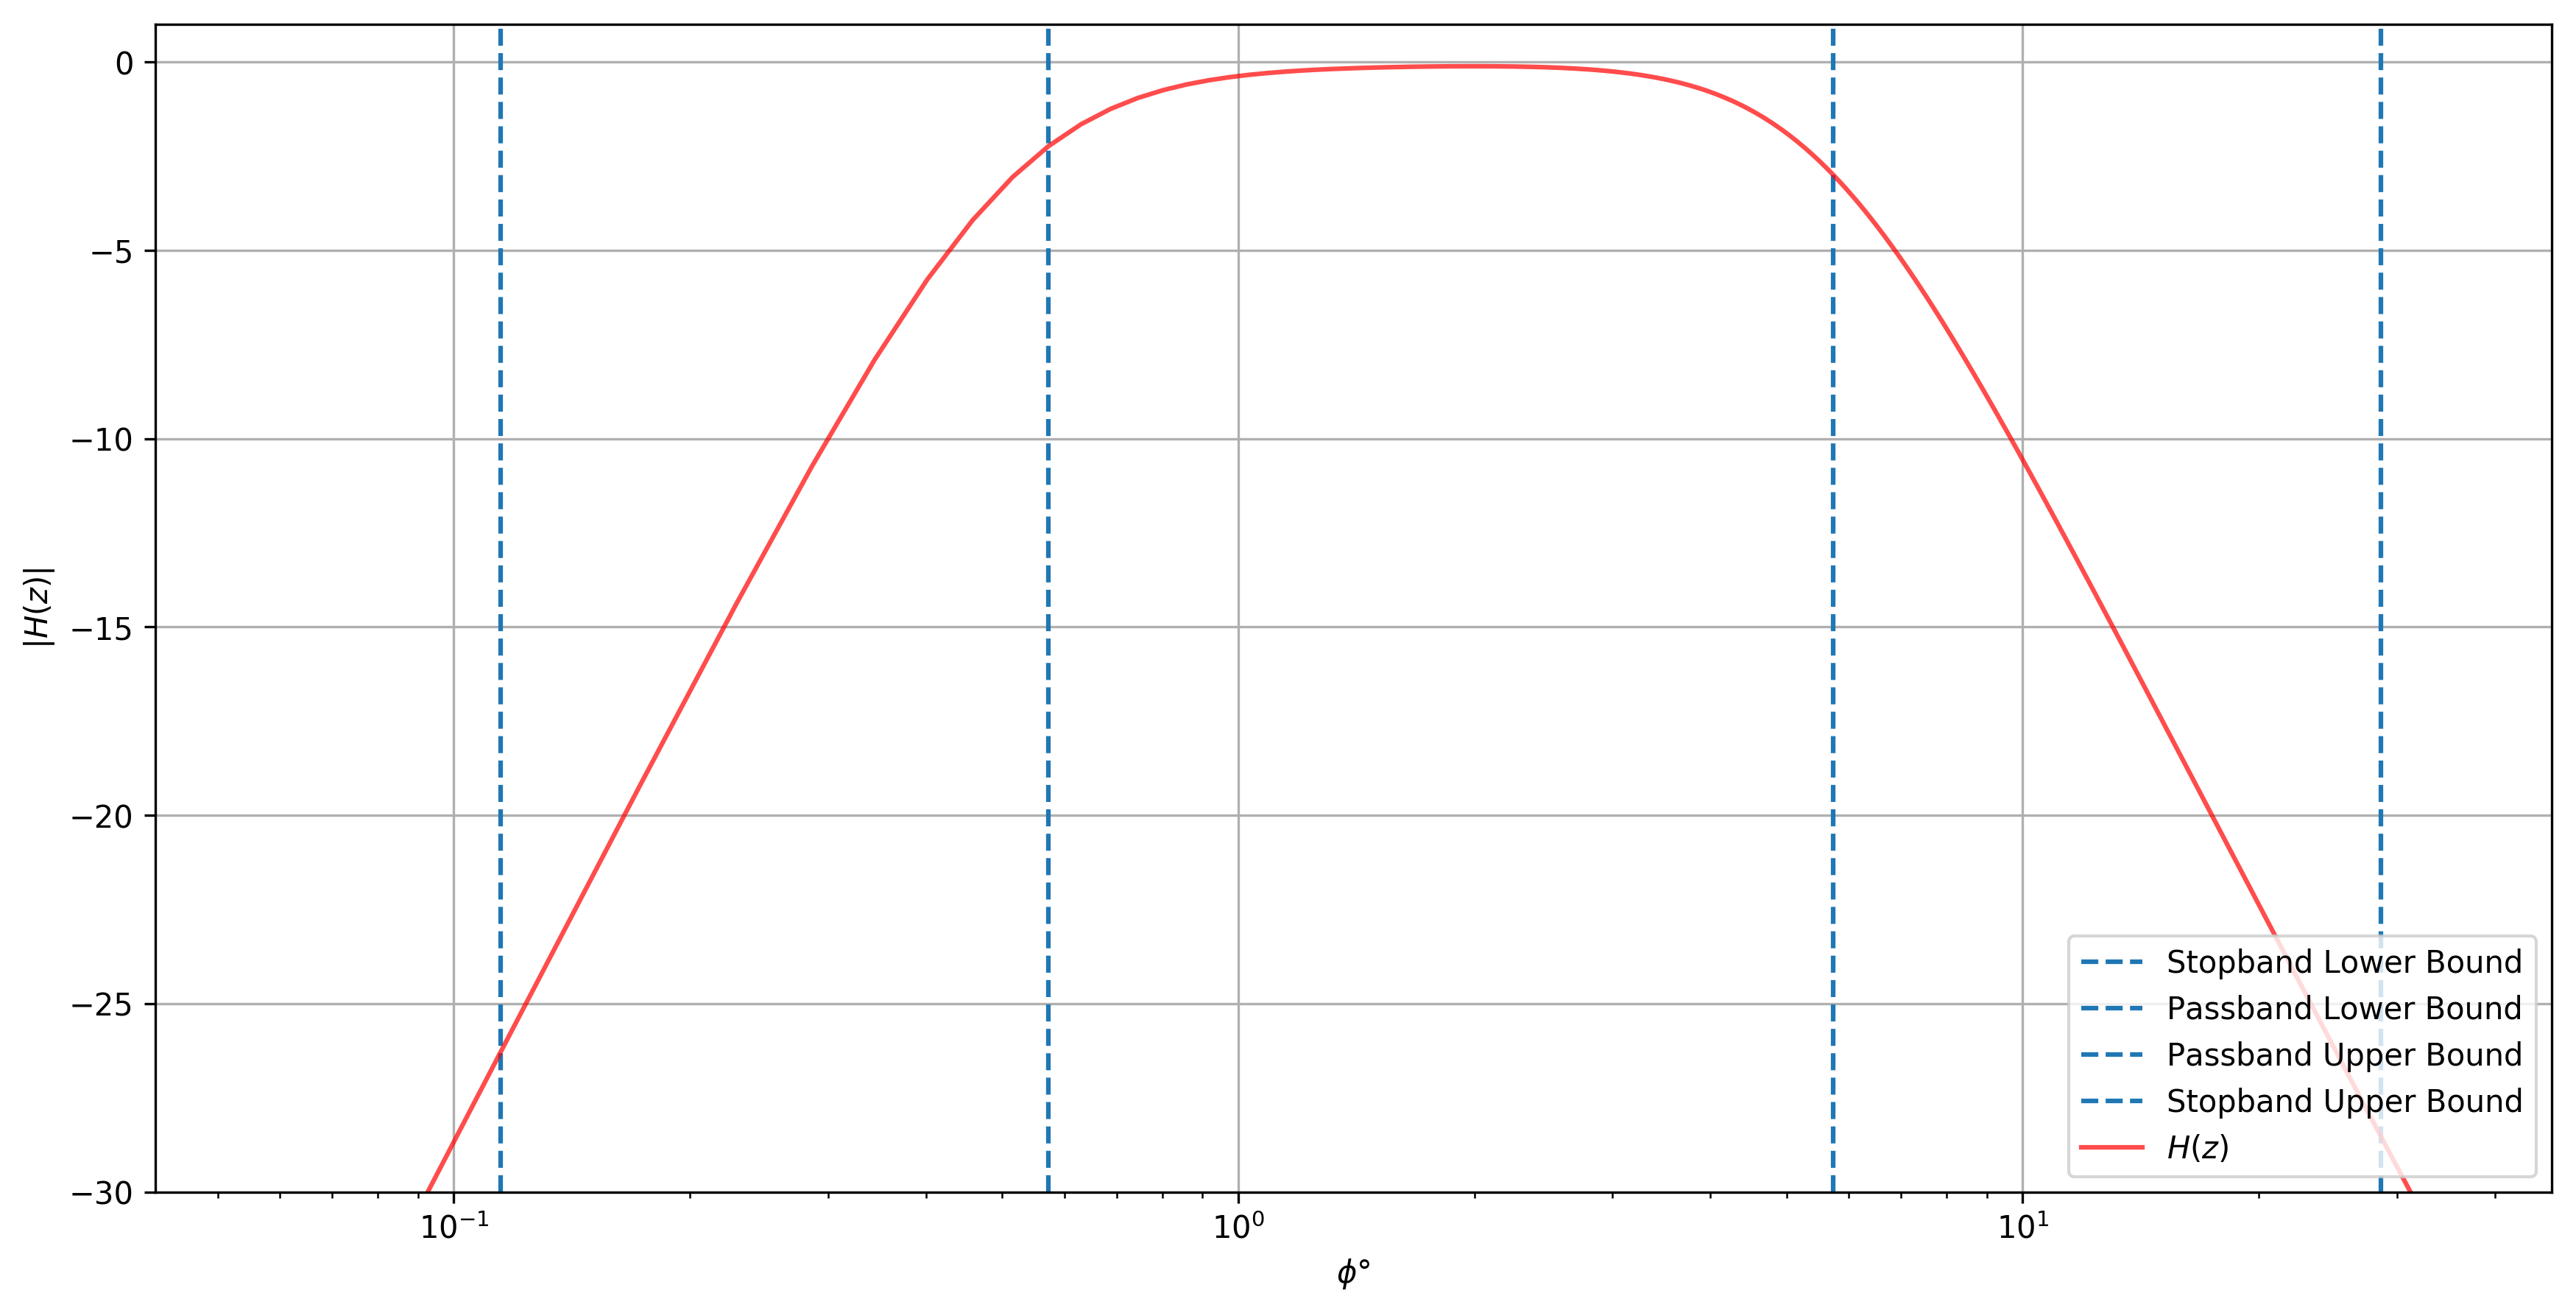

In [13]:
# Sample period
T = 50e-9
# The H(z) transfer function
num = [0.008509703539690870822, -0.017019407079381741644, 0.008509703539690870822,
       7.8886090522101180541e-31, 9.8607613152626475676e-32]
den = [1, -3.8579392997545856723, 5.5842464777865698716,
       -3.5945549738519009091, 0.86824849910120098173]
# Get the significant angles
stopband_low_angle, stopband_high_angle = convert_z_angle(stopband_low, T), convert_z_angle(stopband_high, T)
passband_low_angle, passband_high_angle = convert_z_angle(passband_low, T), convert_z_angle(passband_high, T)

# Plot the z-domain transfer function
x, y = z_plot(num, den, 0.001, [0.00, 0.6])
x, y = np.real(x), np.real(y)
create_plot([x], [(y, )], ["$\phi°$"], ["$|H(z)|$"], [("$H(z)$", )], logx=True,
            y_lines=[[stopband_low_angle, stopband_high_angle,passband_low_angle, passband_high_angle]],
            y_line_labels=[['Stopband Lower Bound', 'Passband Lower Bound',
                            'Passband Upper Bound','Stopband Upper Bound']], ylim=[[-30, 1]], size=(14, 7))


### Verify the backwards rectangular approximation is still valid


In [14]:
df = pd.DataFrame(np.transpose([x, y]), columns=["$\phi°$", "$|H(z)|$"])
display(df.iloc[(df["$\phi°$"] - stopband_low_angle).abs().argsort()[:1]])
display(df.iloc[(df["$\phi°$"] - passband_low_angle).abs().argsort()[:1]])
display(df.iloc[(df["$\phi°$"] - passband_high_angle).abs().argsort()[:1]])
display(df.iloc[(df["$\phi°$"] - stopband_high_angle).abs().argsort()[:1]])

,$\phi°$,$|H(z)|$
2,0.114592,-26.301946


,$\phi°$,$|H(z)|$
10,0.572958,-2.231689


,$\phi°$,$|H(z)|$
100,5.729578,-2.983381


,$\phi°$,$|H(z)|$
500,28.64789,-28.535352



## Problem B

Passband, $\omega \leq 10^4$ and is attenuated $0.85\leq |H|\leq 1$.

Stopband, $\omega \geq 2\cdot 10^4$ and is annenuated $0 \leq |H| \leq 0.15$.

$$T = 10e-6$$

### The input signal


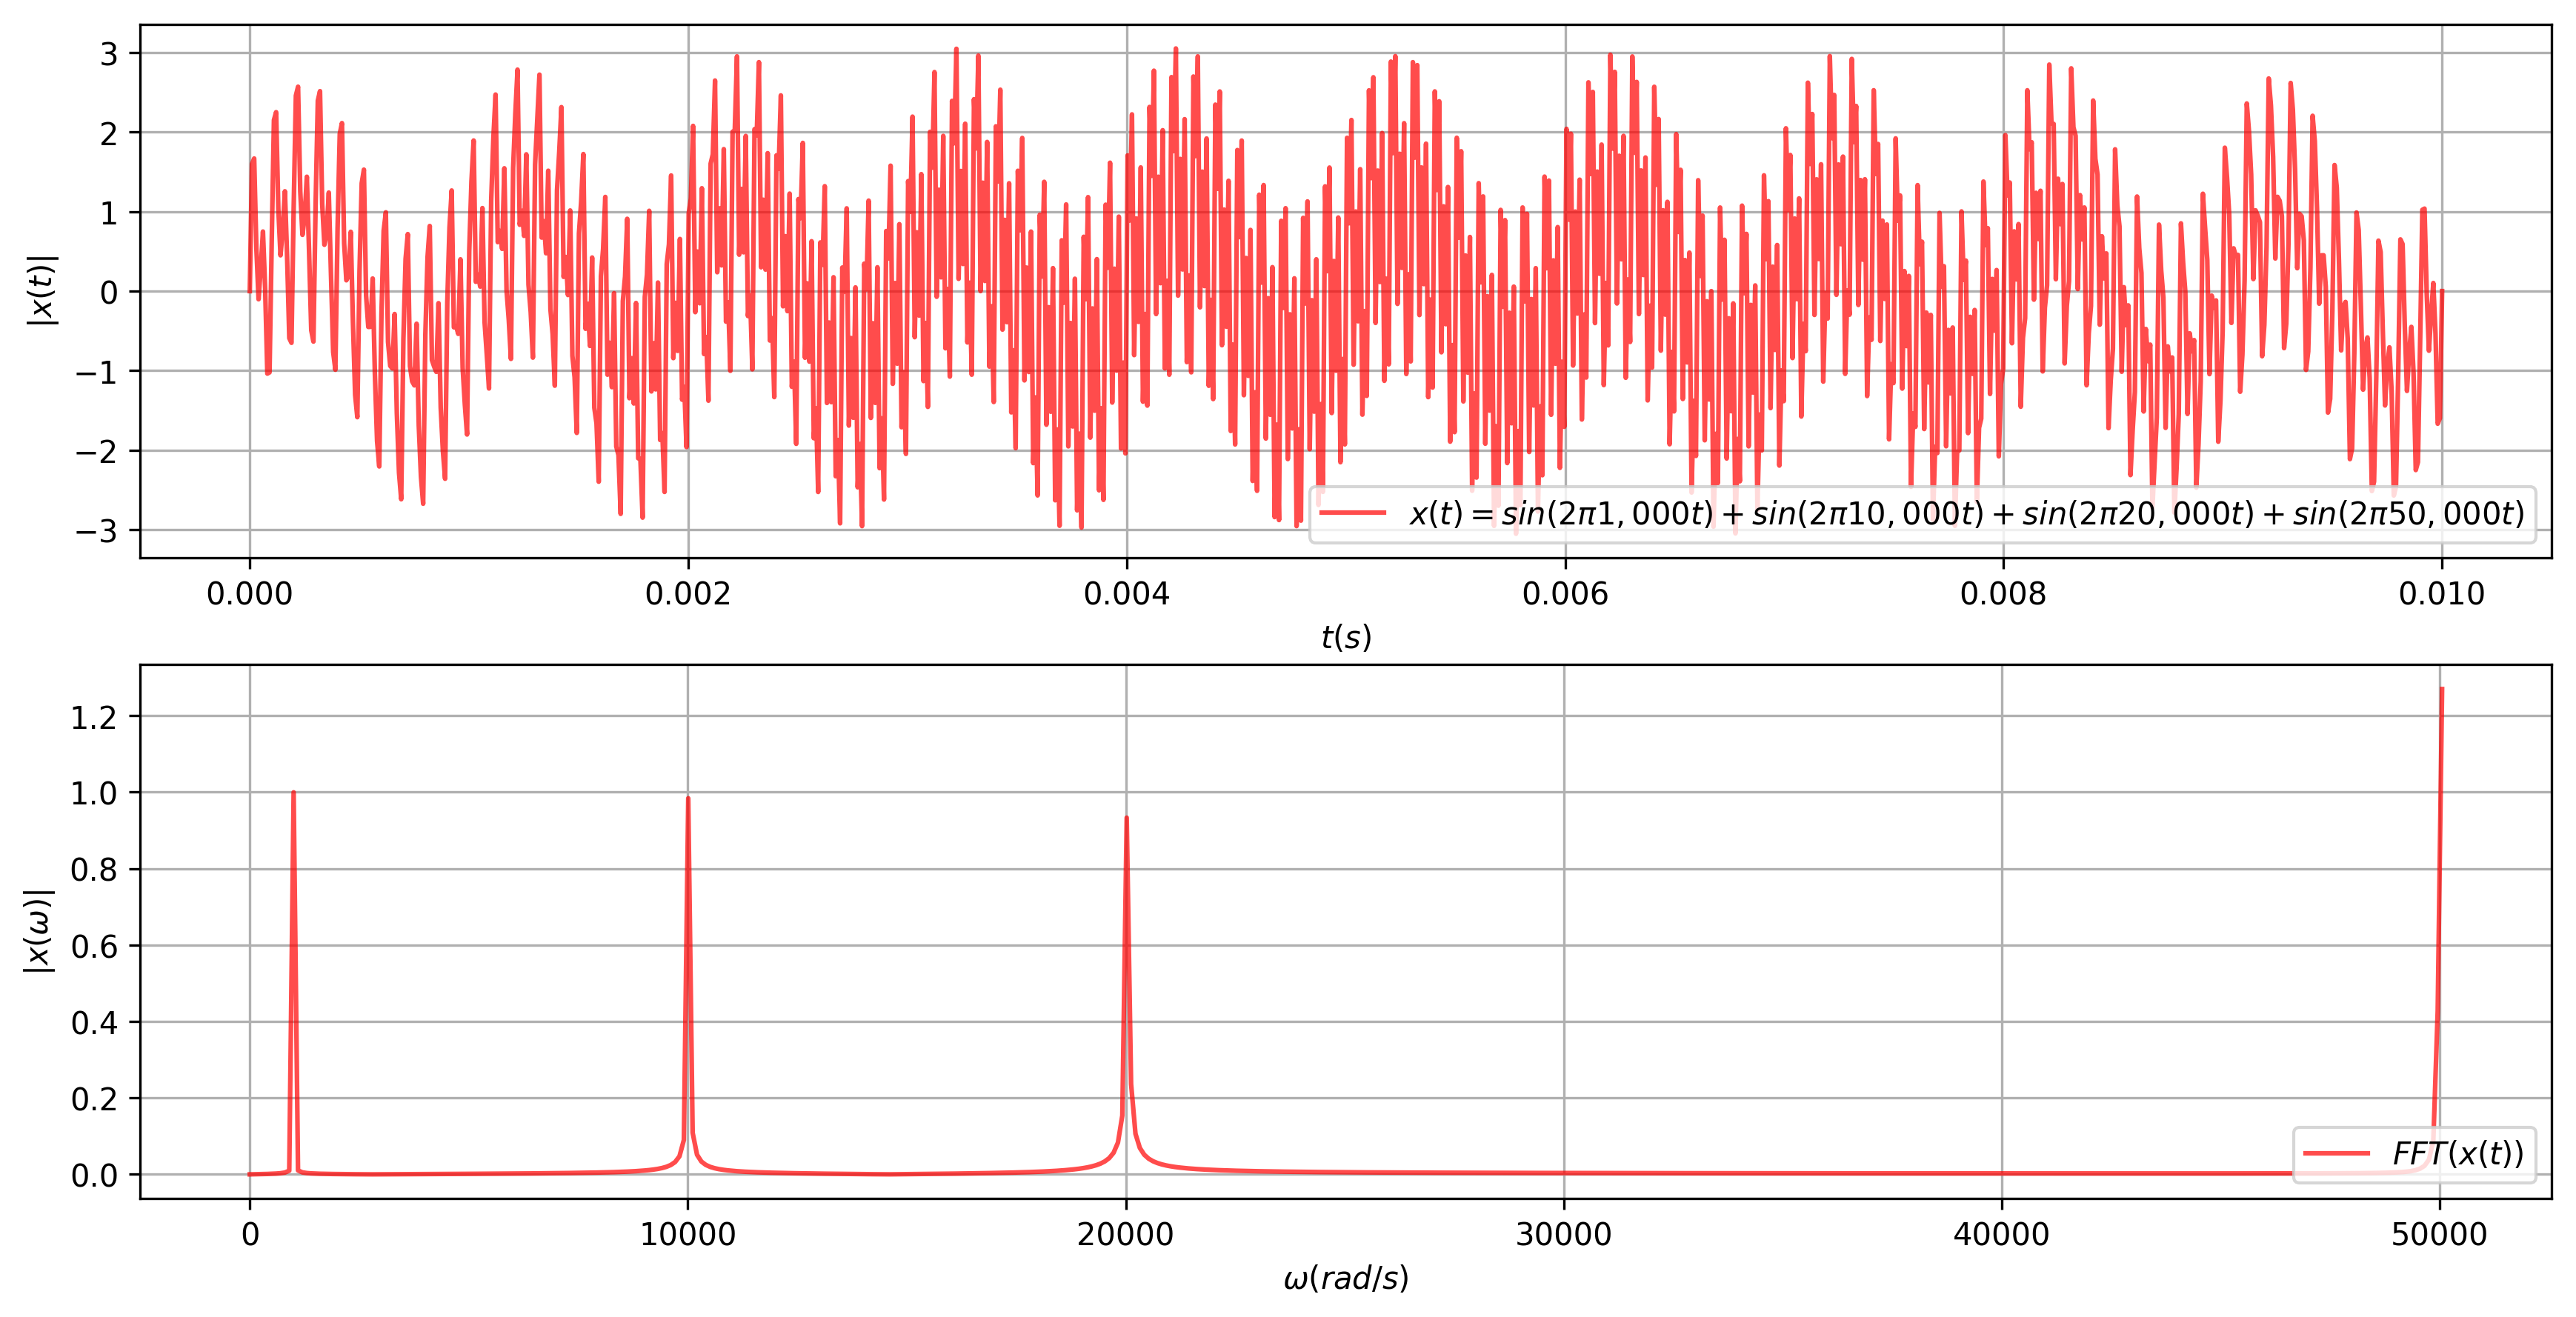

In [15]:
pi2 = 2 * np.pi
T, N = 10e-6, 1000
# The time domain we'll plot against
t = np.linspace(0, N*T, N)
# The input signal has frequencies of 1,000 Hz, 10,000Hz, 20,000Hz, and 50,000Hz
s = np.sin(pi2*1e3*t) + np.sin(pi2*1e4*t) + np.sin(pi2*2e4*t) + np.sin(pi2*5e4*t)
# The FFT of the input signal - ignoring the mirrored frequencies
fft = np.fft.fft(s) * 2 / N
f = np.linspace(0, 1 / T, N)

create_plot([t, f[:N//2+1]], [(s, ), (np.abs(fft)[:N//2+1], )],
            ["$t (s)$", "$\omega (rad/s)$"], ["$|x(t)|$", "$|x(\omega)|$"],
            [("$x(t)=sin(2\pi 1,000t)+sin(2\pi 10,000t)+sin(2\pi 20,000t)+sin(2\pi 50,000t)$", ),
             ("$FFT(x(t))$", )], y_lines=[[np.nan], [np.nan]], y_line_labels=[[""], [""]], size=(14, 7))


### Design the filter


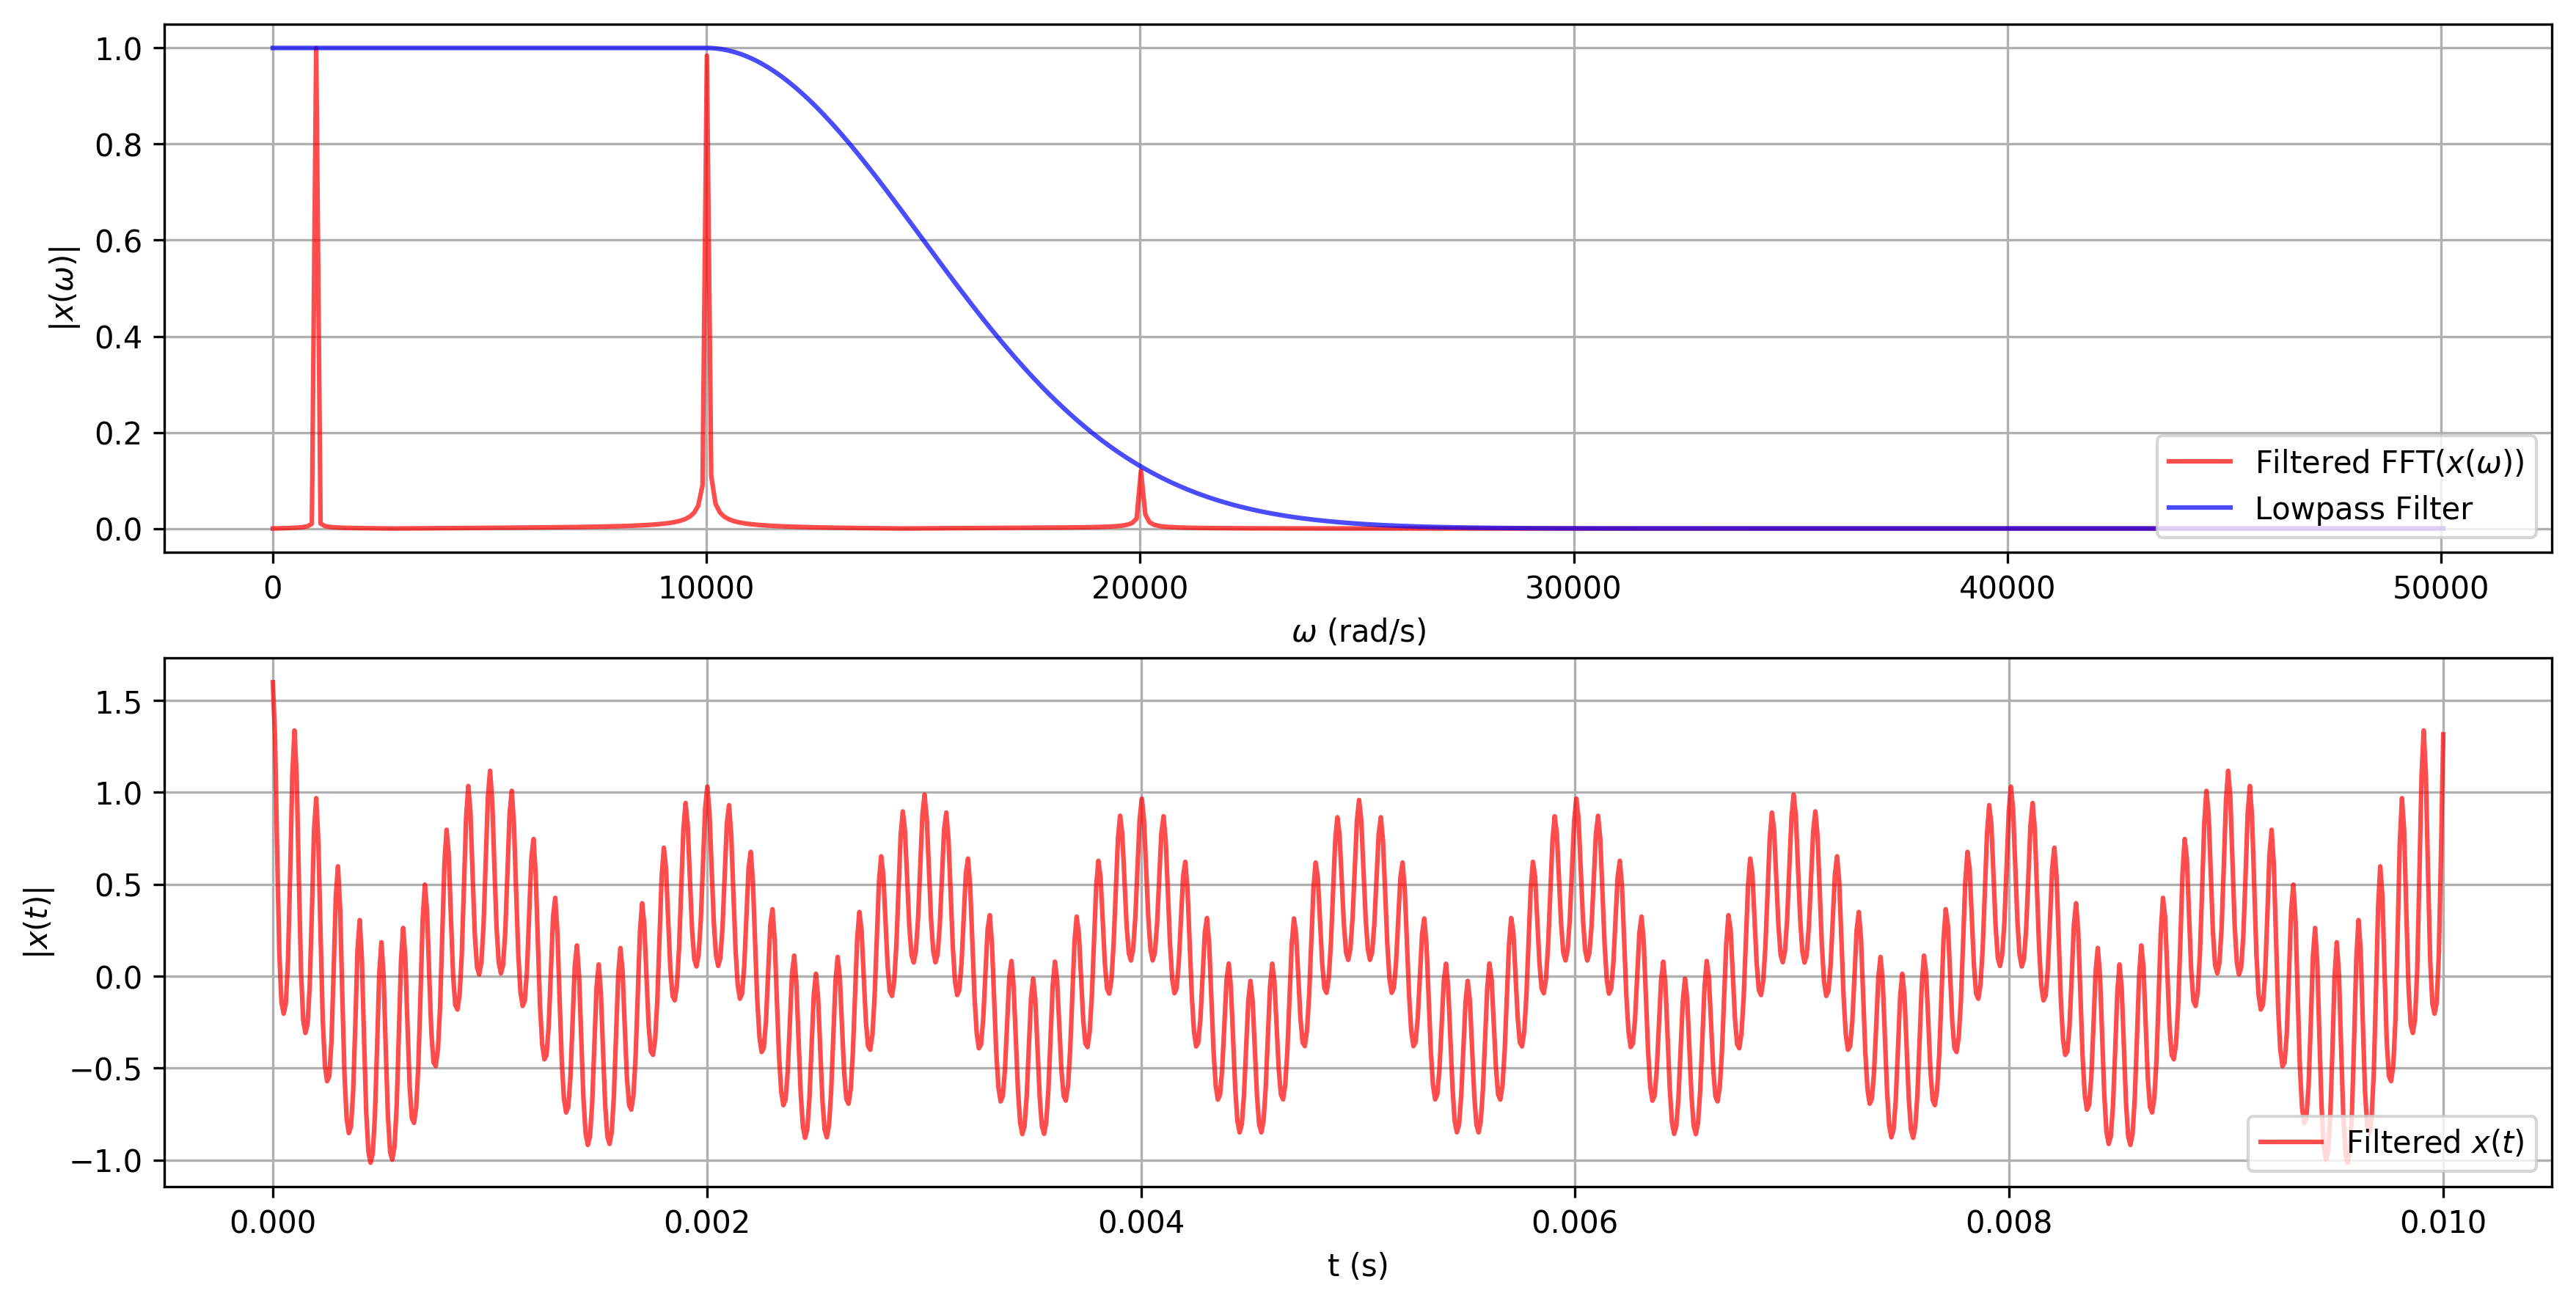

In [27]:
cutoff_freq = 10 ** 4
factor = 4950 # A higher factor means a slower decay - 4650 barely does it
# Design the filter to be zeros and then decaying-exponential after the cutoff frequency
filter_f = [1. if freq <= cutoff_freq else np.exp(-0.5 * (((freq - cutoff_freq) / factor) ** 2)) for freq in f]
# Apply the filter to the input signal's FFT
filtered_fft = np.multiply(np.abs(fft), filter_f)
# Take the IFFT of the filtered signal's FFT
filtered_t = np.fft.ifft(filtered_fft).real * N / 2

create_plot([f[:N//2+1], t], [(filtered_fft[:N//2+1], filter_f[:N//2+1]), (filtered_t, )],
            ["$\omega$ (rad/s)", "t (s)"], ["$|x(\omega)|$", "$|x(t)|$"],
            [("Filtered FFT($x(\omega)$)", "Lowpass Filter"), ("Filtered $x(t)$", )],
            y_lines=[[np.nan], [np.nan]], y_line_labels=[[""], [""]], size=(14, 7))


### Convert the filter from the frequency filter to an FIR filter


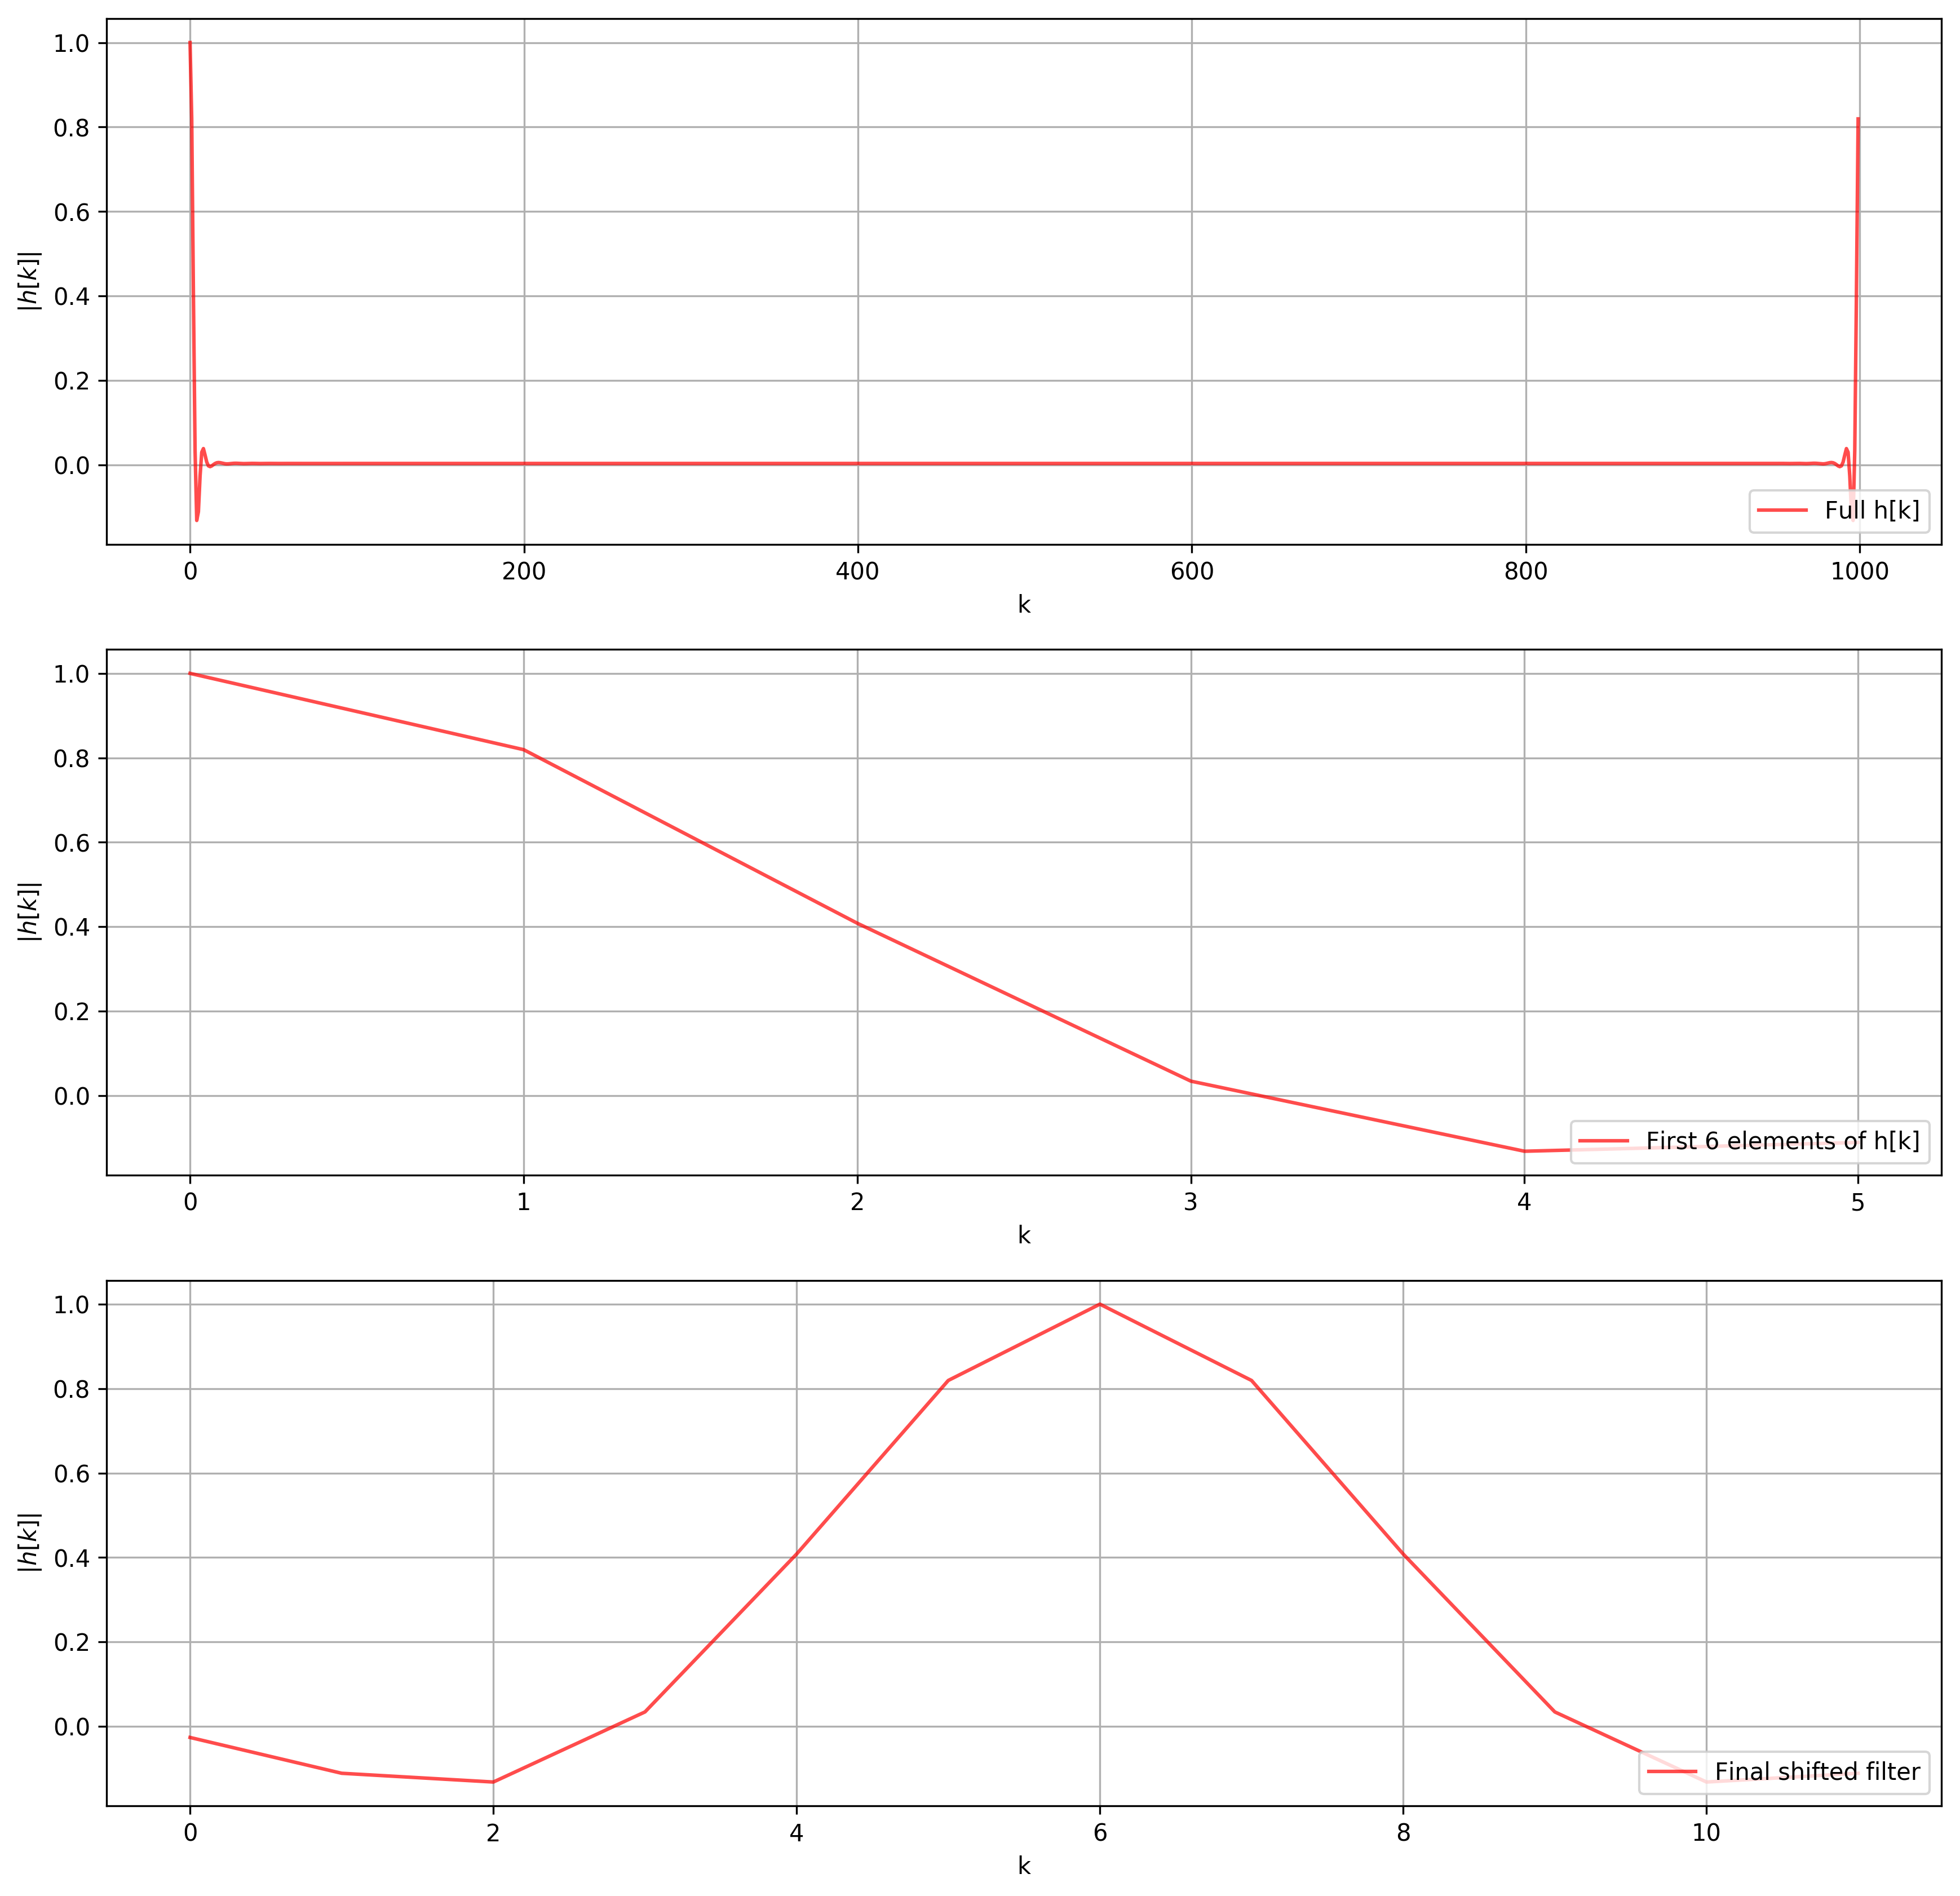

In [29]:
fir_length = 6
# Take the IFFT of the above filter designed above
filter_fir = np.fft.ifft(filter_f).real * N / 2
# Normalize the filter
max_val = max(filter_fir)
filter_fir = [val / max_val for val in filter_fir]
# Create the shifted and shortened filter
final_filter = np.concatenate([filter_fir[-fir_length:], filter_fir[:fir_length]])

create_plot([np.arange(len(filter_fir)), np.arange(fir_length), np.arange(fir_length * 2)],
            [(filter_fir, ), (filter_fir[:fir_length], ), (final_filter, )],
            ["k", "k", "k"], ["$|h[k]|$", "$|h[k]|$", "$|h[k]|$"],
            [("Full h[k]", ), ("First {} elements of h[k]".format(fir_length), ), ("Final shifted filter", )],
            size=(14, 14), y_lines=[[np.nan], [np.nan], [np.nan]], y_line_labels=[[""], [""], [""]])


### Verify the FIR filter works


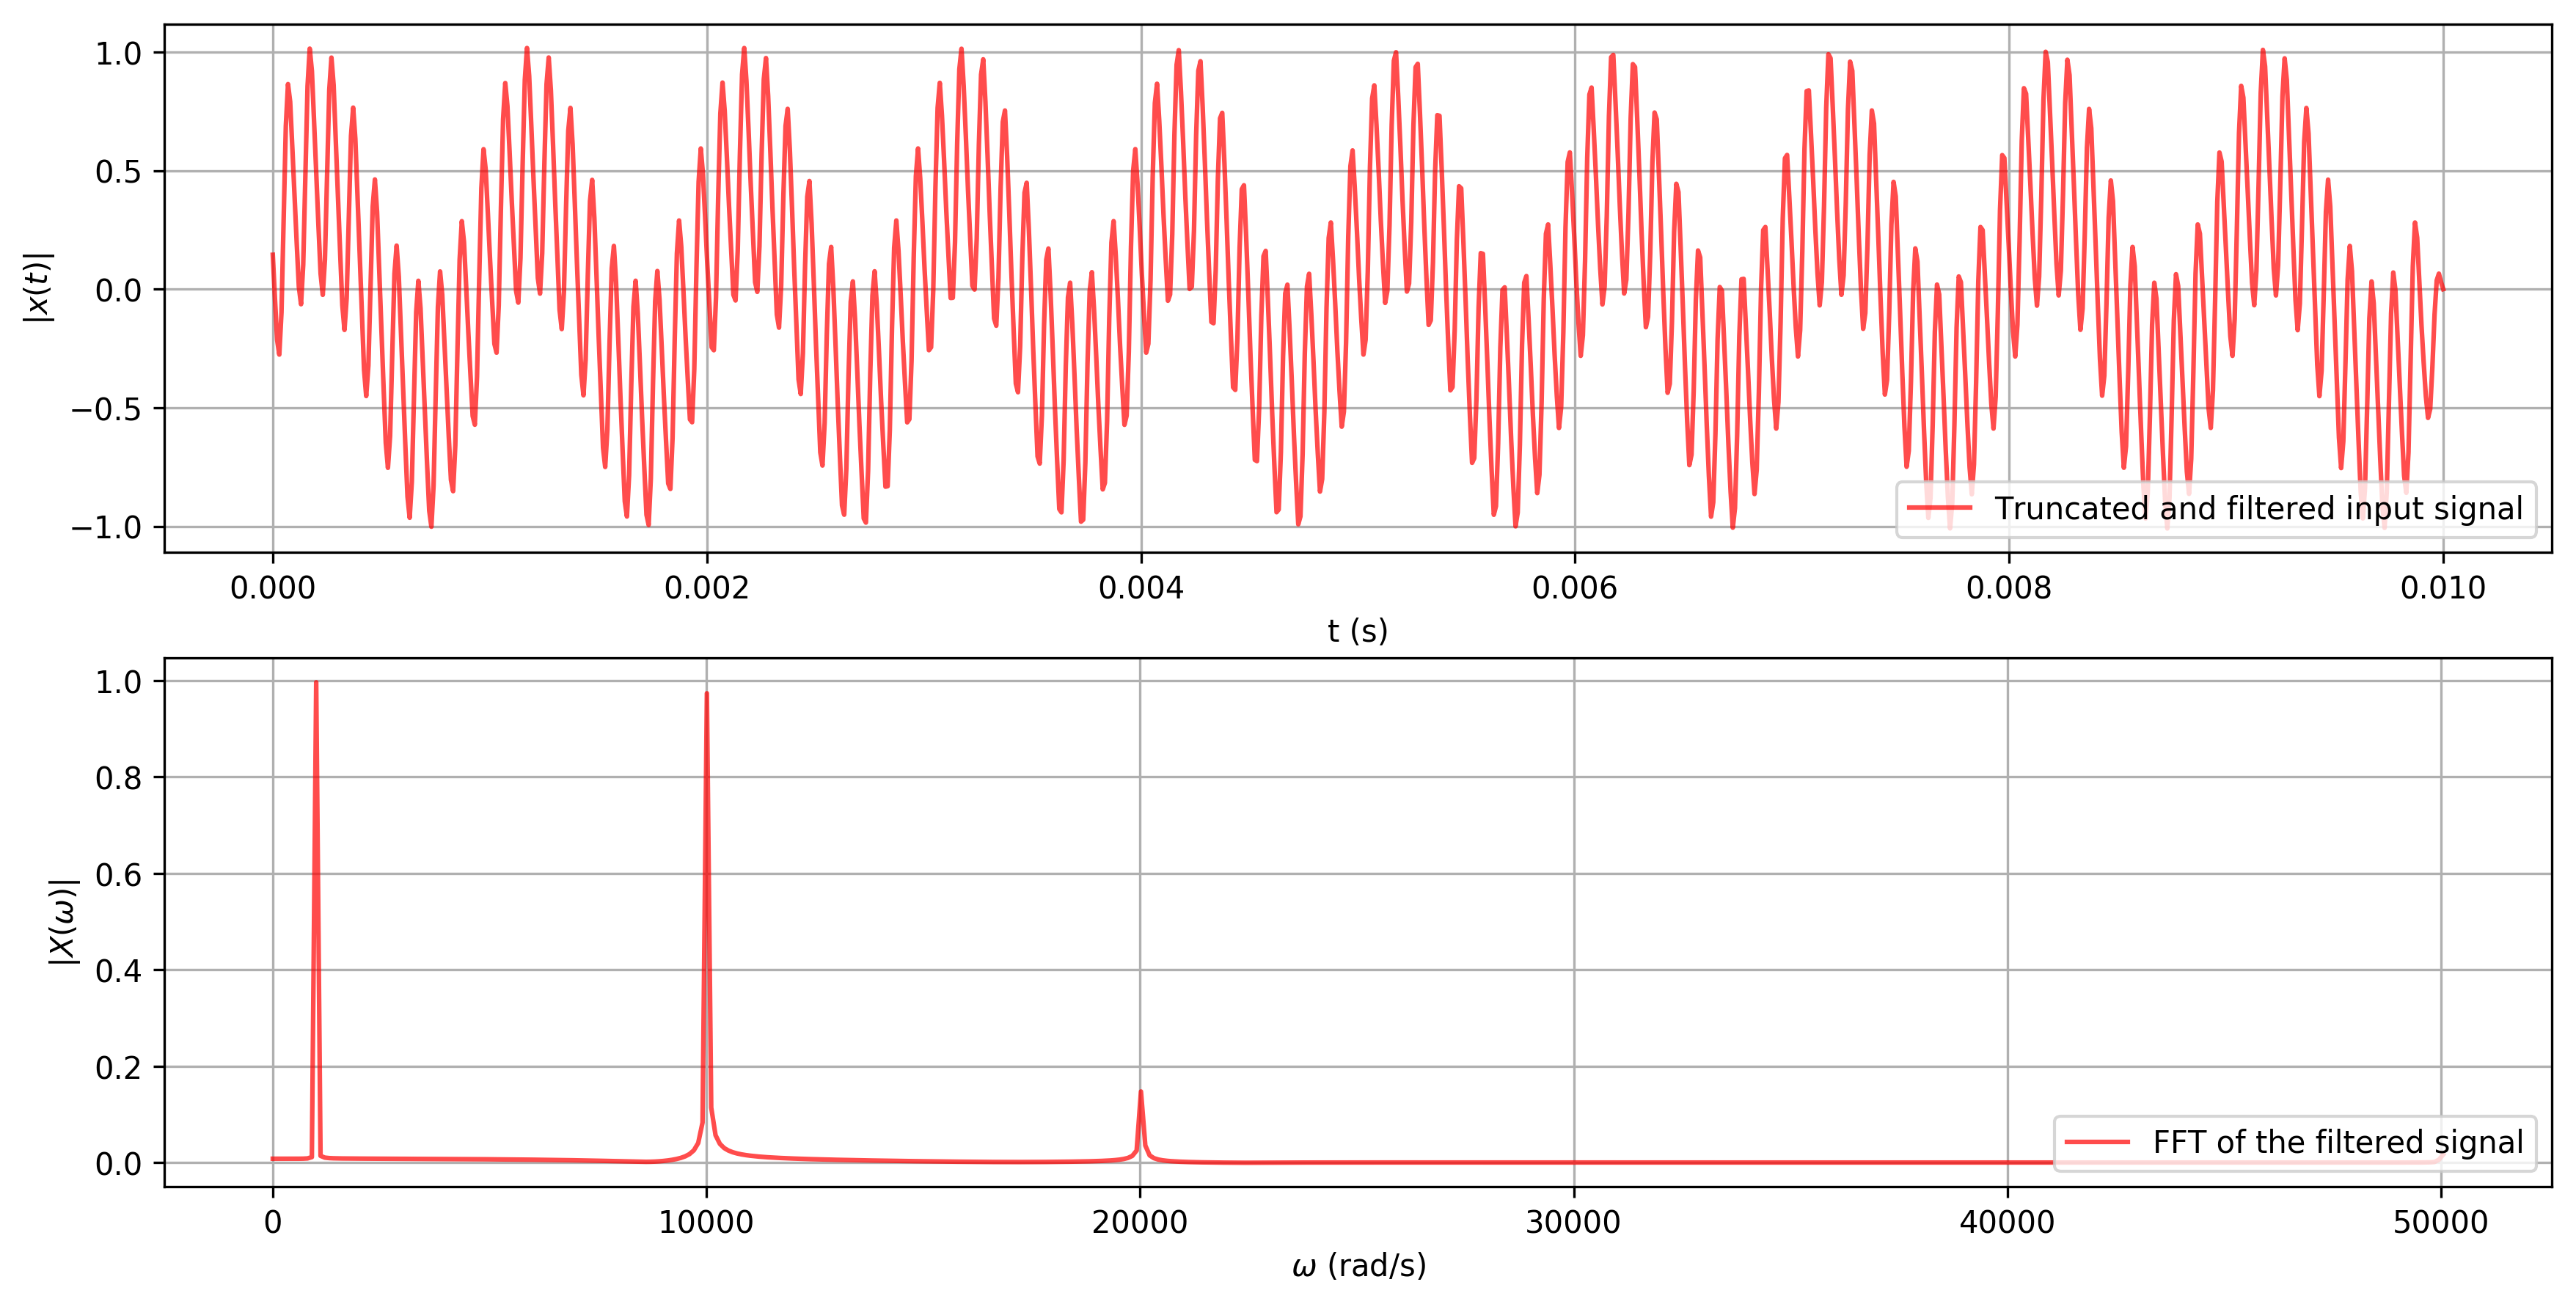

In [30]:
# Convolve the FIR filter with the input signal
final_filtered_t = np.convolve(final_filter, s)
# Shift to ignore the 'startup' phase, and normalize the function
truncated_filtered_t = final_filtered_t[(fir_length * 2)-1:] / 1.5 / sum(abs(final_filter))
# Take the FFT of the filtered signal for verification
final_filtered_fft = np.fft.fft(truncated_filtered_t) * 4 / N

create_plot([t, f[:N//2+1]], [(truncated_filtered_t, ), (np.abs(final_filtered_fft)[:N//2+1], )],
            ["t (s)", "$\omega$ (rad/s)"], ["$|x(t)|$", "$|X(\omega)|$"],
            [("Truncated and filtered input signal", ), ("FFT of the filtered signal", )],
            size=(14, 7), y_lines=[[np.nan], [np.nan]], y_line_labels=[[""], [""], [""]])


### Look at the magnitudes of the input signals to verify their attenuation


In [32]:
df = pd.DataFrame(np.transpose([f[:N//2+1], np.abs(final_filtered_fft)[:N//2+1]]),
                  columns=["Frequency", "Magnitude of FFT(X($\omega$))"])
display(df.iloc[((df['Frequency'] - 1000).abs().argsort())[:1]])
display(df.iloc[((df['Frequency'] - 10000).abs().argsort())[:1]])
display(df.iloc[((df['Frequency'] - 20000).abs().argsort())[:1]])
display(df.iloc[((df['Frequency'] - 50000).abs().argsort())[:1]])

,Frequency,Magnitude of FFT(X($\omega$))
10,1001.001001,0.996236


,Frequency,Magnitude of FFT(X($\omega$))
100,10010.01001,0.973437


,Frequency,Magnitude of FFT(X($\omega$))
200,20020.02002,0.147796


,Frequency,Magnitude of FFT(X($\omega$))
500,50050.05005,0.017076



### The explicit amplitudes of $h[k]$ 


In [33]:
pd.DataFrame(np.transpose([final_filter]), columns=['$h[k]$']).rename_axis('$k$')

,$h[k]$
$k$,
0,-0.026368
1,-0.111207
2,-0.131925
3,0.034091
4,0.408149
5,0.819260
6,1.000000
7,0.819260
8,0.408149
